In [1]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Activation, Input, Conv2DTranspose, Concatenate
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy


c:\Users\willi\Anaconda3\envs\analytics\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\willi\Anaconda3\envs\analytics\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

In [31]:
epochs = 50

LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
#weight_initializer = RandomNormal(stddev=0.02)
weight_initializer=None


gen_g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
gen_f_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
dis_x_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
dis_y_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [3]:
type(weight_initializer)

keras.src.initializers.initializers.RandomNormal

In [11]:
super(keras.src.initializers.initializers.RandomNormal)

NameError: name 'tensorflow' is not defined

keras.src.initializers.initializers.Initializer

In [8]:
import inspect
inspect.getmro(weight_initializer)

AttributeError: 'RandomNormal' object has no attribute '__mro__'

In [4]:
import tensorflow as tf

def preprocess_image(image):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [32]:
def Ck(input, k, use_instancenorm=True):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
    block = LeakyReLU(0.2)(block)

    return block

In [33]:

def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))
    
    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)
    
    dis = Model(dis_input, d)
    dis.compile(loss='mse', optimizer=dis_x_optimizer)
    return dis

In [34]:
# "dk denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def dk(k, use_instancenorm=True):
      block = Sequential()
      block.add(Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
      if use_instancenorm:
          block.add(InstanceNormalization(axis=-1))
      block.add(Activation('relu'))

      return block

  # "uk denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½"
def uk(k):
      # For the implementation: Conv2DTranspose(..., stride=2) = Conv2D(..., stride=0.5)
      block = Sequential()
      block.add(Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
      block.add(InstanceNormalization(axis=-1))
      block.add(Activation('relu'))

      return block

def generator():
      gen_input = Input(shape=(img_rows, img_cols, channels))

      # Layers for the encoder part of the model
      encoder_layers = [
          dk(64, False),
          dk(128),
          dk(256),
          dk(512),
          dk(512),
          dk(512),
          dk(512),
          dk(512)
      ]

      # Layers for the decoder part of the model
      decoder_layers = [
          uk(512),
          uk(512),
          uk(512),
          uk(512),
          uk(256),
          uk(128),
          uk(64)
      ]

      gen = gen_input

      # Add all the encoder layers, and keep track of them for skip connections
      skips = []
      for layer in encoder_layers:
          gen = layer(gen)
          skips.append(gen)

      skips = skips[::-1][1:] # Reverse for looping and get rid of the layer that directly connects to decoder

      # Add all the decoder layers and skip connections
      for skip_layer, layer in zip(skips, decoder_layers):
          gen = layer(gen)
          gen = Concatenate()([gen, skip_layer])


      # Final layer
      gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)

      # Compose model
      return Model(gen_input, gen)

In [35]:
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

In [9]:
loss = BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real, generated):
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

In [11]:
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

In [12]:
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [42]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        print(dis_x_loss)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA
        print(gen_g_loss)

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))


Getting data

In [14]:
import os
import tensorflow as tf
from pathlib import Path
import tensorflow as tf
import numpy as np 
import PIL

In [15]:
sub_dir_list=['trainA', 'trainB']

In [16]:
base_folder=os.path.abspath('../')
raw_data_folder= os.path.join(base_folder, 'data', 'raw', 'monet2photo')
processed_data_folder=os.path.join(base_folder, 'data', 'processed', 'monet2photo')


In [17]:
#Domain A
dom_a_path = os.path.join(os.path.join(processed_data_folder, 'testA'))
dom_a_tfrecord_file=[os.path.join(dom_a_path, filename) for filename in os.listdir(dom_a_path)]

In [18]:
#Domain B
dom_b_path = os.path.join(os.path.join(processed_data_folder, 'testA'))
dom_b_tfrecord_file=[os.path.join(dom_b_path, filename) for filename in os.listdir(dom_b_path)]

In [19]:
# Define a function to parse a TFRecord with a string feature
def parse_tfrecord_fn(record):
    feature_description = {
        'text_feature': tf.io.FixedLenFeature([], dtype=tf.string),
    }
    example = tf.io.parse_single_example(record, feature_description)
    return example

In [20]:
dom_a_raw = tf.data.TFRecordDataset(dom_a_tfrecord_file)
dom_b_raw = tf.data.TFRecordDataset(dom_b_tfrecord_file)

In [21]:
dom_a_parsed = dom_a_raw.map(parse_tfrecord_fn)
dom_b_parsed = dom_b_raw.map(parse_tfrecord_fn)

In [22]:
batch_size = 32
buffer_size = 1000
dom_a_train = dom_a_parsed.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size)
dom_b_train = dom_b_parsed.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size)


In [23]:
import time

In [38]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)
        print(dis_y_loss)
         

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

            print(discriminator_y_gradients)

        return 
        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
        
        
        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)
        
        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
        

In [43]:
# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((dom_a_train, dom_b_train))):
        real_x_img=[np.array(tf.keras.utils.load_img(fpath.numpy().decode('utf-8'))) for fpath in real_x['text_feature']]
        real_y_img=[np.array(tf.keras.utils.load_img(fpath.numpy().decode('utf-8'))) for fpath in real_y['text_feature']]

        real_x_img_processed=list(map(preprocess_image, real_x_img))
        real_y_img_processed=list(map(preprocess_image, real_y_img))

        for batch in range(len(real_x_img_processed)): 
            step(real_x_img_processed[batch], real_y_img_processed[batch])
            break
            print(f"Completed batch instance : {batch}")
        break 

        if k % 100 == 0: print(k)

        print(f"Completed batch : {k}")

    print('Time taken: {}'.format(time.time() - start))
    break


Epoch: 0
Tensor("mul_1:0", shape=(), dtype=float32)
Tensor("add_4:0", shape=(), dtype=float32)
Time taken: 60.721219062805176


Viewing output image from example

In [23]:
import matplotlib.pyplot as plt

path_to_example_test = os.path.join(raw_data_folder , 'trainB', '2013-11-08 16_45_24.jpg')
raw_img_data = np.array(tf.keras.utils.load_img(path_to_example_test))
img_processed = preprocess_image(raw_img_data)

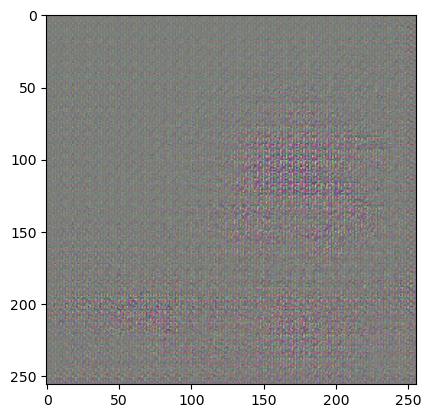

In [24]:
#Epoch 0 
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

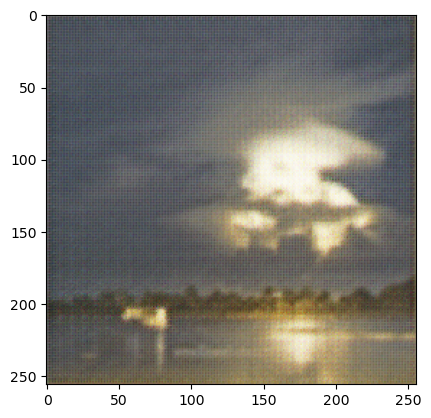

In [27]:
#Epoch 1
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

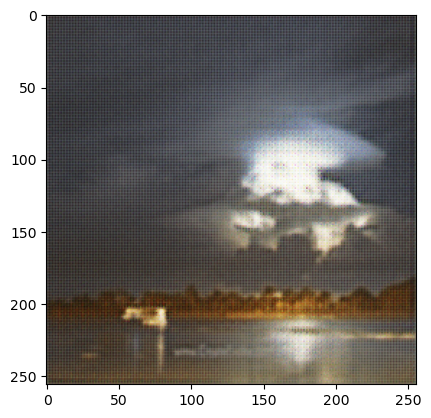

In [29]:
#Epoch 2
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

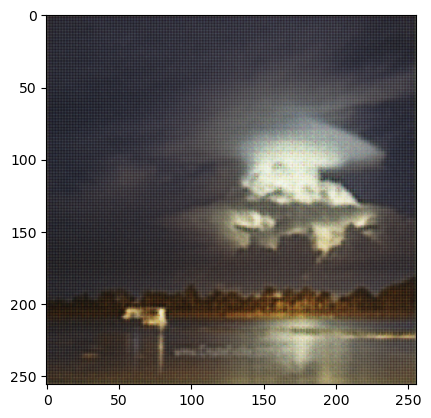

In [31]:
#Epoch 3
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

In [ ]:
#Epoch 4
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

In [ ]:
#Epoch 5
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

In [88]:
#Epoch 6
transfered_img = generator_f(img_processed, training=True)
rescaled_img=(transfered_img +  1) * 127.5
plt.imshow(rescaled_img.numpy()[0].astype('uint8'))

In [ ]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))


In [ ]:
# Read and parse the TFRecord
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

# Iterate over the parsed dataset
for record in parsed_dataset:
    text_feature = record['text_feature'].numpy().decode('utf-8')
    print(text_feature)

In [91]:

# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((train_x, train_y))):
        if k % 100 == 0: print(k)
        # Train step
        step(tf.reshape(real_x, (1, img_rows, img_cols, channels)), tf.reshape(real_y, (1, img_rows, img_cols, channels)))
    
    print('Time taken: {}'.format(time.time() - start))

"""for _ in range(10):
    generate_images()
"""

Epoch: 0


TypeError: Invalid input to `zip`. Inputs are expected to be (nested) structures of `tf.data.Dataset` objects but encountered object of type <class 'tensorflow.python.framework.ops.EagerTensor'>.

BLOCKS:

In [13]:
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))
    
    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)
    
    dis = Model(dis_input, d)
    dis.compile(loss='mse', optimizer=dis_x_optimizer)
    return dis

In [15]:
def generator():
      gen_input = Input(shape=(img_rows, img_cols, channels))

      # Layers for the encoder part of the model
      encoder_layers = [
          dk(64, False),
          dk(128),
          dk(256),
          dk(512),
          dk(512),
          dk(512),
          dk(512),
          dk(512)
      ]

      # Layers for the decoder part of the model
      decoder_layers = [
          uk(512),
          uk(512),
          uk(512),
          uk(512),
          uk(256),
          uk(128),
          uk(64)
      ]

      gen = gen_input

      # Add all the encoder layers, and keep track of them for skip connections
      skips = []
      for layer in encoder_layers:
          gen = layer(gen)
          skips.append(gen)

      skips = skips[::-1][1:] # Reverse for looping and get rid of the layer that directly connects to decoder

      # Add all the decoder layers and skip connections
      for skip_layer, layer in zip(skips, decoder_layers):
          gen = layer(gen)
          gen = Concatenate()([gen, skip_layer])


      # Final layer
      gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)

      # Compose model
      return Model(gen_input, gen)

In [16]:
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

ValueError: Invalid value for argument `filters`. Expected a strictly positive value. Received filters=False.